In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras
import tensorflow.keras as K
import tensorflow.keras.backend as Kback

from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import DenseNet121, NASNetMobile, EfficientNetB0, Xception
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

In [4]:
dataset="/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"

In [5]:
import os

dataset_folder_path = "/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"
folder_contents = os.listdir(dataset_folder_path)

# Filter out only the directories (folders)
folders = [item for item in folder_contents if os.path.isdir(os.path.join(dataset_folder_path, item))]

# Print the list of folders
print("Folders in the dataset:")
for folder in folders:
    print(folder)


Folders in the dataset:
Normal cases
Malignant cases
Bengin cases


In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the base path to your dataset
base_path = '/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset'

# List of class names (A, B, C)
class_names =  ["Normal cases", "Malignant cases", "Bengin cases"]

# Initialize empty lists for images and labels
all_images = []
all_labels = []

# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as RGB


        # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (224, 224))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        all_images.append(img)
        all_labels.append(label)


In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
all_images_flat = [img.flatten() for img in all_images]

<ipython-input-10-099aa627adf3>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', len(class_names))


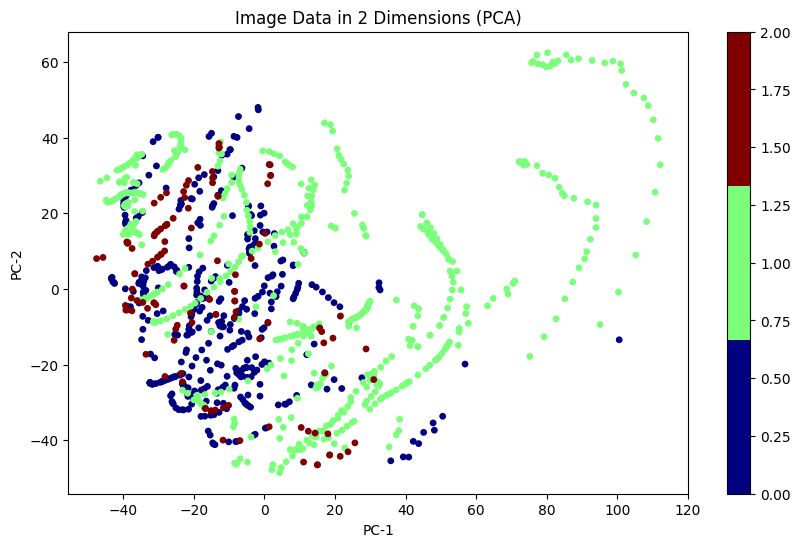

In [10]:
# # Flatten images
# all_images_flat = [img.flatten() for img in all_images]

# # Apply PCA with 2 components
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(all_images_flat)

# # Visualize the reduced data
# plt.figure(figsize=(10, 6))
# c_map = plt.cm.get_cmap('jet', len(class_names))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=15, cmap=c_map, c=all_labels)
# plt.colorbar()
# plt.xlabel('PC-1')
# plt.ylabel('PC-2')
# plt.title('Image Data in 2 Dimensions (PCA)')
# plt.show()

In [9]:
# Split into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images_flat, all_labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Apply PCA with 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train)  # Use only training data for PCA


<ipython-input-11-70d2dea08ba3>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', len(class_names))


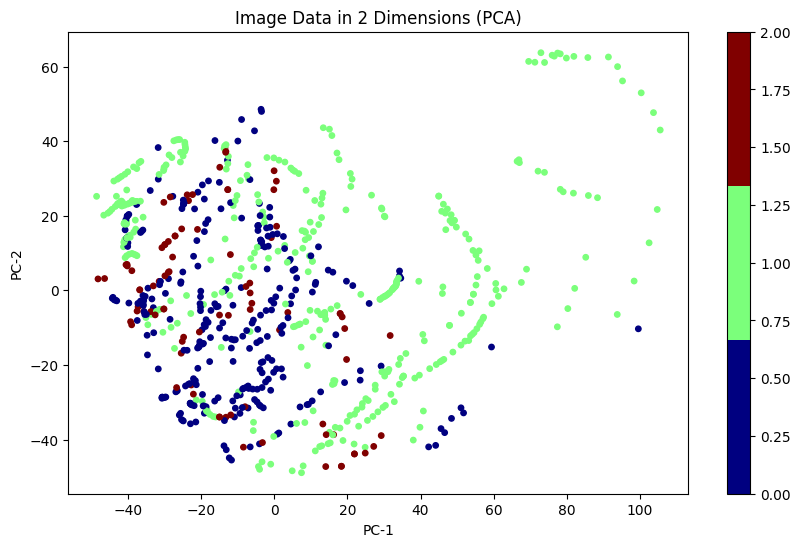

In [11]:
# Visualize the reduced data (optional)
plt.figure(figsize=(10, 6))
c_map = plt.cm.get_cmap('jet', len(class_names))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=15, cmap=c_map, c=y_train)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Image Data in 2 Dimensions (PCA)')
plt.show()


In [12]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



In [13]:
y_train_encoded = to_categorical(y_train, num_classes=len(class_names))
y_test_encoded = to_categorical(y_test, num_classes=len(class_names))
y_valid_encoded= to_categorical(y_valid, num_classes=len(class_names))

In [14]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid= np.array(X_valid)

In [15]:
X_train = X_train.reshape(-1, 224, 224, 3)
X_test = X_test.reshape(-1, 224, 224, 3)
X_valid = X_valid.reshape(-1, 224, 224, 3)

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


NUM_CLASSES = 3
# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(len(class_names), activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False



vgg_model.summary()



58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                         

In [17]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.CategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=10
batch_size=32
history= vgg_model.fit(X_train,y_train_encoded, epochs=20, batch_size=32,validation_data=(X_valid, y_valid_encoded))



Epoch 1/20
24/24 [==============================] - 22s 539ms/step - loss: 1.0809 - accuracy: 0.6349 - val_loss: 0.3479 - val_accuracy: 0.8667
Epoch 2/20
24/24 [==============================] - 4s 179ms/step - loss: 0.2841 - accuracy: 0.8814 - val_loss: 0.2026 - val_accuracy: 0.9333
Epoch 3/20
24/24 [==============================] - 4s 181ms/step - loss: 0.1511 - accuracy: 0.9439 - val_loss: 0.1355 - val_accuracy: 0.9515
Epoch 4/20
24/24 [==============================] - 4s 158ms/step - loss: 0.0596 - accuracy: 0.9896 - val_loss: 0.1221 - val_accuracy: 0.9515
Epoch 5/20
24/24 [==============================] - 4s 180ms/step - loss: 0.0529 - accuracy: 0.9870 - val_loss: 0.1037 - val_accuracy: 0.9576
Epoch 6/20
24/24 [==============================] - 4s 159ms/step - loss: 0.0698 - accuracy: 0.9713 - val_loss: 0.1228 - val_accuracy: 0.9576
Epoch 7/20
24/24 [==============================] - 4s 182ms/step - loss: 0.0432 - accuracy: 0.9831 - val_loss: 0.0626 - val_accuracy: 0.9758
Epoch

In [18]:
test_loss, test_accuracy = vgg_model.evaluate(X_test,y_test_encoded)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

6/6 [==============================] - 1s 113ms/step - loss: 0.0853 - accuracy: 0.9697
Test Loss: 0.08528890460729599
Test Accuracy: 0.9696969985961914


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt




6/6 [==============================] - 1s 142ms/step


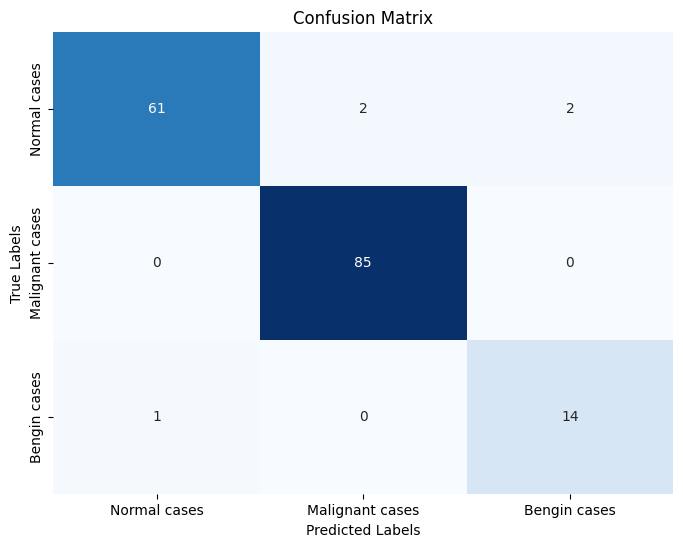

                 precision    recall  f1-score   support

   Normal cases       0.98      0.94      0.96        65
Malignant cases       0.98      1.00      0.99        85
   Bengin cases       0.88      0.93      0.90        15

       accuracy                           0.97       165
      macro avg       0.95      0.96      0.95       165
   weighted avg       0.97      0.97      0.97       165



In [24]:

y_pred = vgg_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)



# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))

In [25]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.5569701248841623

In [26]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.5607616511493626

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

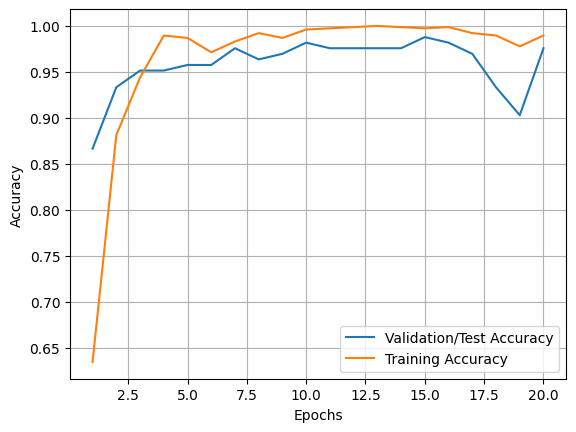

In [27]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

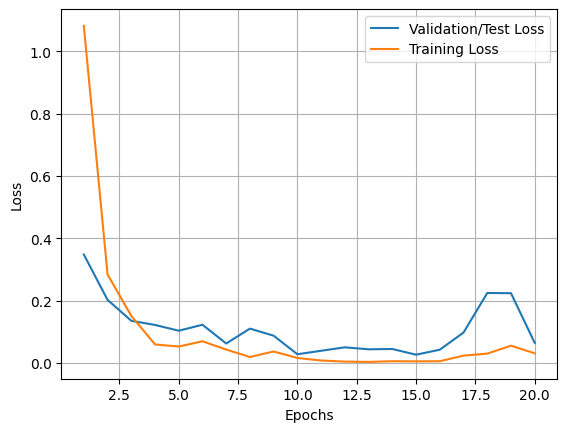

In [28]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()